In [1]:
import os
import glob
import pickle
import sys  

sys.path.insert(0, '../py')
from graviti import *

import numpy as np
import pandas as pd

from  matplotlib import pyplot
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import seaborn

import umap

import warnings
warnings.filterwarnings('ignore')

In [2]:
def classify(df_2d,tissue,umap_nn):
    n_neighbors = 15

    # we only take the first two features. We could avoid this ugly
    # slicing by using a two-dim dataset
    X = df_2d[['x','y']].to_numpy()
    y = df_2d.target

    # Create color maps
    cmap = ListedColormap(['grey','blue'])
    
    for weights in ['distance']: #['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        plt.figure(figsize=(15,15))
        
        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], 
                    c=y, cmap=cmap,
                    alpha=0.5,
                    #edgecolor='k', 
                    s=20)
        plt.xlim(X[:, 0].min()-1.0, X[:, 0].max()+1.0)
        plt.ylim(X[:, 1].min()-1.0, X[:, 1].max()+1.0)
        #plt.title("3-Class classification (k = %i, weights = '%s')"
        plt.savefig(str(tissue)+'_'+str(umap_nn)+'.png')
    
    plt.show()
    return

In [3]:
# Load the data
data = np.load('../py/covd_barycenters.npy') # array of sample covd baryncenters

filename = 'list_of_cancerID.pkl'            # list of cancer types
infile = open(filename,'rb')
target = pickle.load(infile)
infile.close()

print(data.shape,len(target))

(5094, 36) 5094


In [4]:
# Project to lowD using UMAP
umap_nn = 100
min_dist = 0
reducer = umap.UMAP(n_components=2, n_neighbors=umap_nn, min_dist=min_dist)
embedding = reducer.fit_transform(data)

# Define dataframe in lowD
df_2d =  pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1], tissue=target))

In [5]:
# K-means classification
from sklearn.cluster import KMeans
X = embedding
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
#print(set(kmeans.labels_))

#Split dataset according to cluster labels
df_2d['cluster'] = kmeans.labels_
df_2d.head()

,x,y,tissue,cluster
0,13.286505,3.025123,PRAD,1
1,14.268940,2.535175,PRAD,1
2,-4.895069,0.333778,PRAD,0
3,13.000237,2.590111,PRAD,1
4,-5.667168,-1.296873,PRAD,0


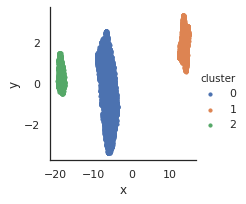

In [6]:
# Show the cluster to study
import seaborn
seaborn.set(style='white')

fg = seaborn.FacetGrid(data=df_2d[['x','y','cluster']], 
                       hue='cluster')
fg.map(pyplot.scatter, 'x', 'y',s=10).add_legend()

In [ ]:
# Evaluate the distance structure of the individual clusters considering the neighborhood of each sample
from sklearn.neighbors import NearestNeighbors

cluster_ID = 'all' # select the cluster to study

if cluster_ID == 'all':
    df_cluster = df_2d # consider all samples
else: # 0,1 or 2
    df_cluster = df_2d[df_2d['cluster']==cluster_ID] # select the cluster to study    

X = df_cluster[['x','y']].to_numpy()
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

# Create a dataframe with inter-tissue proximity countings
import collections
from collections import Counter

inter_tissue_df = pd.DataFrame()
for idx in range(indices.shape[0]):
    list_of_tissues = [ df_cluster['tissue'].to_list()[i] for i in list(indices[idx]) ]
    source = list_of_tissues[0]
    c = Counter(list_of_tissues)
    df = pd.DataFrame.from_dict(c, orient='index').reset_index()
    df = df.rename(columns={'index':'target', 0:'count'}) 
    df['source'] = df.shape[0]*[source] # add the source tissue column
    inter_tissue_df = inter_tissue_df.append(df)

pv_data = pd.pivot_table(inter_tissue_df, index=["source"], columns=["target"], values=["count"], aggfunc=np.sum)

c = Counter(df_cluster['tissue'].to_list())
df_pmi = pd.DataFrame()
for s in set(inter_tissue_df.source):
    for t in set(inter_tissue_df.target):
        num = pv_data.loc[s,('count', t)]
        den = c[s]*c[t]
        pmi = np.log(df_cluster.shape[0]*num/den) # the cooccurrence is evaluated using an analogue of the pointwise mutual information

        df0 = pd.DataFrame([[s,t,num,c[s],c[t],pmi]], 
                           columns=['source','target','cooccurence','source_count','target_count','pmi'])
        
        df_pmi = df_pmi.append( df0 )

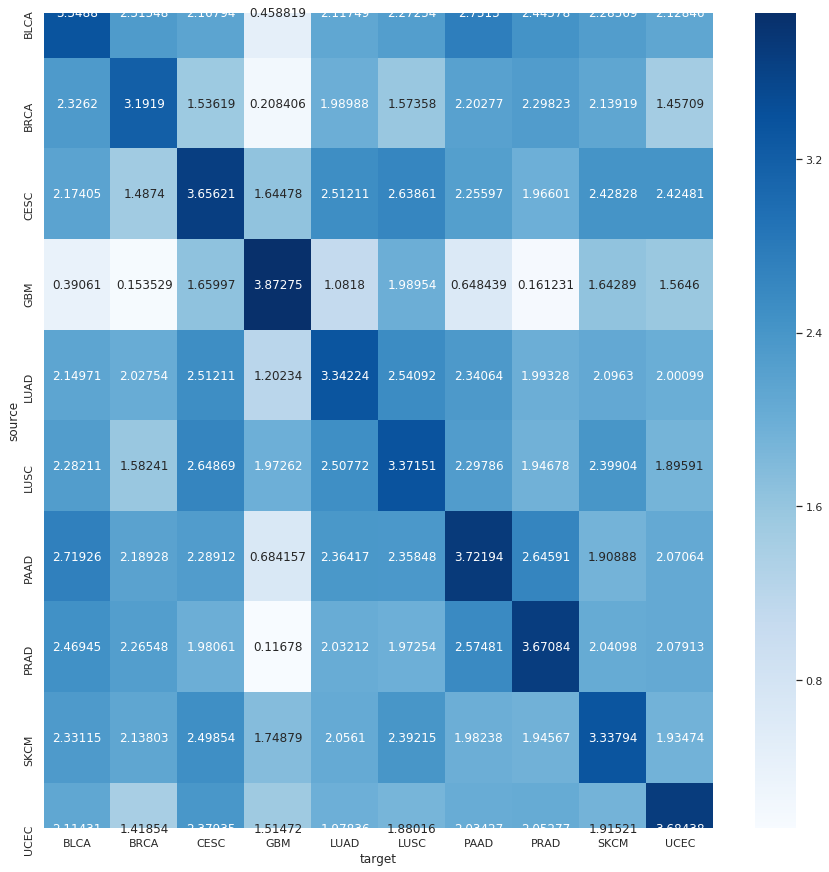

In [15]:
import seaborn as sns

pv_pmi = df_pmi.pivot(index='source',columns='target',values='pmi')
plt.figure(figsize=(15,15))
sns.heatmap(pv_pmi,annot=True, fmt="g", cmap="Blues")

filename = 'pmi_cluster'+str(cluster_ID)+'.10nn'
plt.savefig(filename+'.png')
df_pmi.to_csv(filename+'.csv')

In [8]:
df_pmi.pivot(index='source',columns='target',values='pmi')

target,BLCA,BRCA,CESC,GBM,LUAD,LUSC,PAAD,PRAD,SKCM,UCEC
source,,,,,,,,,,
BLCA,3.348800,2.315479,2.167937,0.458819,2.117493,2.272543,2.751301,2.445783,2.285686,2.128457
BRCA,2.326199,3.191904,1.536186,0.208406,1.989884,1.573577,2.202772,2.298231,2.139188,1.457085
CESC,2.174053,1.487396,3.656212,1.644784,2.512105,2.638609,2.255970,1.966007,2.428275,2.424809
GBM,0.390610,0.153529,1.659974,3.872748,1.081802,1.989539,0.648439,0.161231,1.642889,1.564602
LUAD,2.149706,2.027539,2.512105,1.202336,3.342235,2.540915,2.340636,1.993280,2.096303,2.000990
LUSC,2.282112,1.582407,2.648693,1.972625,2.507724,3.371512,2.297860,1.946785,2.399041,1.895910
PAAD,2.719261,2.189277,2.289122,0.684157,2.364167,2.358485,3.721943,2.645909,1.908876,2.070637
PRAD,2.469453,2.265481,1.980606,0.116780,2.032120,1.972537,2.574813,3.670845,2.040982,2.079131
SKCM,2.331149,2.138030,2.498545,1.748795,2.056097,2.392152,1.982379,1.945671,3.337935,1.934739


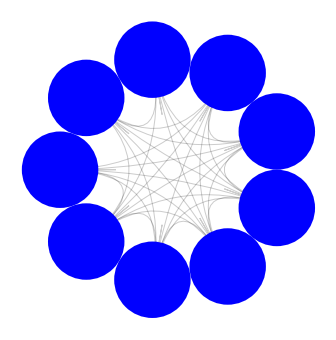

In [65]:
from nxviz.plots import CircosPlot
import networkx as nx

df_new = inter_tissue_df.groupby(['source','target']).sum().reset_index()

G=nx.from_pandas_edgelist(df_new,'source', 'target', edge_attr=True)

c = CircosPlot(G)
c.draw()
plt.show()

In [ ]:
# Plot the distribution of inter-tissue distances
reference = list(set(target)) 
for s in reference:
    for t in reference:
        print(s,t)
        pair_instance_df = inter_tissue_df[(inter_tissue_df['source']==s) & (inter_tissue_df['target']==t)]
        pair_instance_df.hist(column='count',bins=20)
        plt.show()

In [ ]:
# Evaluate pairwise inter-sample distances
from sklearn.metrics.pairwise import euclidean_distances

delta_lowD = euclidean_distances(embedding)

# Plot the pairwise sample distance for each cancer type
for tissue in set(target):
    print(tissue)
    row0 = target.index(tissue); row1 = row0+Counter(target)[tissue]
    col0 = target.index(tissue); col1 = col0+Counter(target)[tissue]
    plt.hist(delta_lowD[row0:row1,col0:col1].flatten(),bins=50)
    plt.show()

# Plot the pairwise sample distance for each pair of cancer type
for s in set(target):
    for t in list(set(target))[:10]:
        print(s,t)
        row0 = target.index(s); row1 = row0+Counter(target)[s]
        col0 = target.index(t); col1 = col0+Counter(target)[t]
        plt.hist(delta_lowD[row0:row1,col0:col1].flatten(),bins=50)
        plt.show()

In [ ]:
# Project to lowD
umap_nn = 200
min_dist = 0
reducer = umap.UMAP(n_components=2, n_neighbors=umap_nn, min_dist=min_dist)
embedding = reducer.fit_transform(data)

# Define dataframe in lowD
df_2d =  pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1], label=target))

for tissue in list(set(df_2d.label))[:]:
    print(tissue)
    df_2d['target'] = [ df_2d.label.to_list()[s] == tissue for s in range(df_2d.shape[0]) ]
    
    classify(df_2d, tissue, umap_nn)

In [69]:
# Create a dataframe with inter-tissue distance distances
import collections
from collections import Counter

inter_tissue_df = pd.DataFrame()
for idx in range(indices.shape[0]):
    list_of_tissues = [ df_cluster['tissue'].to_list()[i] for i in list(indices[idx]) ]
    deltas = [distances[idx][i] for i in range(distances.shape[1])]

    source = list_of_tissues[0]
    list_0 = list(zip(list_of_tissues,deltas))
    c = Counter()
    for k,v in list_0: # for a given sample group the distances to all other neighborhood samples 
        c.update({k:v})
    df = pd.DataFrame.from_dict(c, orient='index').reset_index()
    df = df.rename(columns={'index':'target', 0:'distance'}) 
    df['source'] = df.shape[0]*[source] # add the source tissue column
    inter_tissue_df = inter_tissue_df.append(df)
    #print(inter_tissue_df.sort_values(by=['distance']))

pv_data = pd.pivot_table(inter_tissue_df, index=["source"], columns=["target"], values=["distance"], aggfunc=np.mean)
pv_data.to_csv('pivot_interTissue.distance.count.10nn.csv')
